PRM - planning methods
======================

This code is part of the course "Introduction to robot path planning" (Author: Bjoern Hein).


License is based on Creative Commons: Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) (pls. check: http://creativecommons.org/licenses/by-nc/4.0/)

**Attention**: This worksheet has external dependencies 

* to the files "InnoKonz2dEnv.py" or "InnoKonzShapelyEnv.py". These files contain simple 2D environments based on numpy arrays or the shapely library with an interface for the use as collision checking in the algorithms.
* to the file "PlanerBasics.py", which contains the BaseClass for all planning algorithms 

Important links are:

    General Info: http://www.python.org
    Python tutorial http://www.python.org/doc/tut/
    NetworkX http://networkx.github.io/
    NumPy and SciPy Guide http://docs.scipy.org/
    Matplotlib gallery http://matplotlib.sourceforge.net/gallery.html
    

Remember that:

    you have to press ctrl-return or shift-return, to execute the code in the code sections, only then the variables are "generated" and can be used
    you can execute the whole notebook by Cell->runAll





Import modules
--------------

following modules will be needed to run this notebook:

In [1]:
import sys
sys.path.append("templates")
%load_ext autoreload
%autoreload 2
from IPPerfMonitor import IPPerfMonitor


import networkx as nx
import random
import numpy as np
import math

from scipy.spatial import cKDTree

#reload modules if changed externally e.g. InnoKonz2DEnv.
%load_ext autoreload 
%autoreload 2
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Visibility Roadmap
==================

*Slightly modified* as described in the slides. See comments in code

In [2]:
import IPPRMBase

class VisibilityStatsHandler():
    
    def __init__(self):
        self.graph = nx.Graph()
        
    def addNodeAtPos(self,nodeNumber,pos):
        self.graph.add_node(nodeNumber, pos=pos, color='yellow')
        return
    
    def addVisTest(self,fr,to):
        self.graph.add_edge(fr, to)
        return
        
class VisPRM(IPPRMBase.PRMBase):
    """Class implements an simplified version of a visibility PRM"""

    def __init__(self, _collChecker, _statsHandler = None):
        super(VisPRM, self).__init__(_collChecker)
        self.graph = nx.Graph()
        self.statsHandler = VisibilityStatsHandler()
                
    def _isVisible(self, pos, guardPos):
        return not self._collisionChecker.lineInCollision(pos, guardPos)

    def _learnRoadmap(self, ntry):

        nodeNumber = 0
        currTry = 0
        while currTry < ntry:
            #print currTry
            # select a random  free position
            q_pos = self._getRandomFreePosition()
            if self.statsHandler:
                self.statsHandler.addNodeAtPos(nodeNumber, q_pos)
           
            g_vis = None
        
            # every connected component represents one guard
            merged = False
            for comp in nx.connected_components(self.graph): # Impliciteley represents G_vis
                found = False
                merged = False
                for g in comp: # connected components consists of guards and connection: only test nodes of type 'Guards'
                    if self.graph.nodes[g]['nodeType'] == 'Guard':
                        if self.statsHandler:
                            self.statsHandler.addVisTest(nodeNumber, g)
                        if self._isVisible(q_pos,self.graph.nodes[g]['pos']):
                            found = True
                            if g_vis == None:
                                g_vis = g
                            else:
                                self.graph.add_node(nodeNumber, pos = q_pos, color='lightblue', nodeType = 'Connection')
                                self.graph.add_edge(nodeNumber, g)
                                self.graph.add_edge(nodeNumber, g_vis)
                                #print "ADDED Connection node", nodeNumber
                                merged = True
                        # break, if node was visible,because visibility from one node of the guard is sufficient...
                        if found == True: break;
                # break, if connection was found. Reason: computed connected components (comp) are not correct any more, 
                # they've changed because of merging
                if merged == True: # how  does it change the behaviour? What has to be done to keep the original behaviour?
                    break;                    

            if (merged==False) and (g_vis == None):
                self.graph.add_node(nodeNumber, pos = q_pos, color='red', nodeType = 'Guard')
                #print "ADDED Guard ", nodeNumber
                currTry = 0
            else:
                currTry += 1

            nodeNumber += 1

    def planPath(self, startList, goalList, config):
        """
        
        Args:
            start (array): start position in planning space
            goal (array) : goal position in planning space
            config (dict): dictionary with the needed information about the configuration options
            
        Example:
        
            config["ntry"] = 40 
        
        """
        # 0. reset
        self.graph.clear()
        
        # 1. check start and goal whether collision free (s. BaseClass)
        checkedStartList, checkedGoalList = self._checkStartGoal(startList,goalList)
        
        # 2. learn Roadmap
        self._learnRoadmap(config["ntry"])

        # 3. find connection of start and goal to roadmap
        # find nearest, collision-free connection between node on graph and start
        posList = nx.get_node_attributes(self.graph,'pos')
        kdTree = cKDTree(list(posList.values()))
        
        result = kdTree.query(checkedStartList[0],k=5)
        for node in result[1]:
            if not self._collisionChecker.lineInCollision(checkedStartList[0],self.graph.nodes[list(posList.keys())[node]]['pos']):
                 self.graph.add_node("start", pos=checkedStartList[0], color='lightgreen')
                 self.graph.add_edge("start", list(posList.keys())[node])
                 break

        result = kdTree.query(checkedGoalList[0],k=5)
        for node in result[1]:
            if not self._collisionChecker.lineInCollision(checkedGoalList[0],self.graph.nodes[list(posList.keys())[node]]['pos']):
                 self.graph.add_node("goal", pos=checkedGoalList[0], color='lightgreen')
                 self.graph.add_edge("goal", list(posList.keys())[node])
                 break

        try:
            path = nx.shortest_path(self.graph,"start","goal")
        except:
            return []
        return path


Tests
----

In [3]:
def visibilityPRMVisualize(planner, solution, ax = None, nodeSize = 300):
    # get a list of positions of all nodes by returning the content of the attribute 'pos'
    graph = planner.graph
    statsHandler = planner.statsHandler
    collChecker = planner._collisionChecker
    pos = nx.get_node_attributes(graph,'pos')
    color = nx.get_node_attributes(graph,'color')
    
    if statsHandler:
        statPos = nx.get_node_attributes(statsHandler.graph,'pos')
        nx.draw(statsHandler.graph, pos=statPos, alpha=0.2,edge_color='y',node_size=nodeSize)
        
    # draw graph (nodes colorized by degree)
    nx.draw(graph, pos = pos, nodelist=list(color.keys()), with_labels=True, node_color = list(color.values())) 
    nx.draw_networkx_edges(graph,pos,
                               edge_color='b',
                               width=3.0
                            )
   
    collChecker.drawObstacles(ax)
    # get nodes based on solution path
    Gsp = nx.subgraph(graph,solution)

    # draw edges based on solution path
    nx.draw_networkx_edges(Gsp,pos,alpha=0.8,edge_color='g',width=10, label="Solution Path")
        
    # draw start and goal
    # draw start and goal
    if "start" in graph.nodes(): 
        nx.draw_networkx_nodes(graph,pos,nodelist=["start"],
                                   node_size=nodeSize,
                                   node_color='#00dd00',  ax = ax)
    if "goal" in graph.nodes():
        nx.draw_networkx_nodes(graph,pos,nodelist=["goal"],
                                   node_size=nodeSize,
                                   node_color='#00dd00',  ax = ax)


In [4]:
import matplotlib.pylab as plt 
from shapely.geometry import Point, Polygon, LineString
from IPEnvironment import CollisionChecker
from IPVISBasicPRM import basicPRMVisualize

In [5]:
import IPTestSuite

In [6]:
benchList = IPTestSuite.benchList

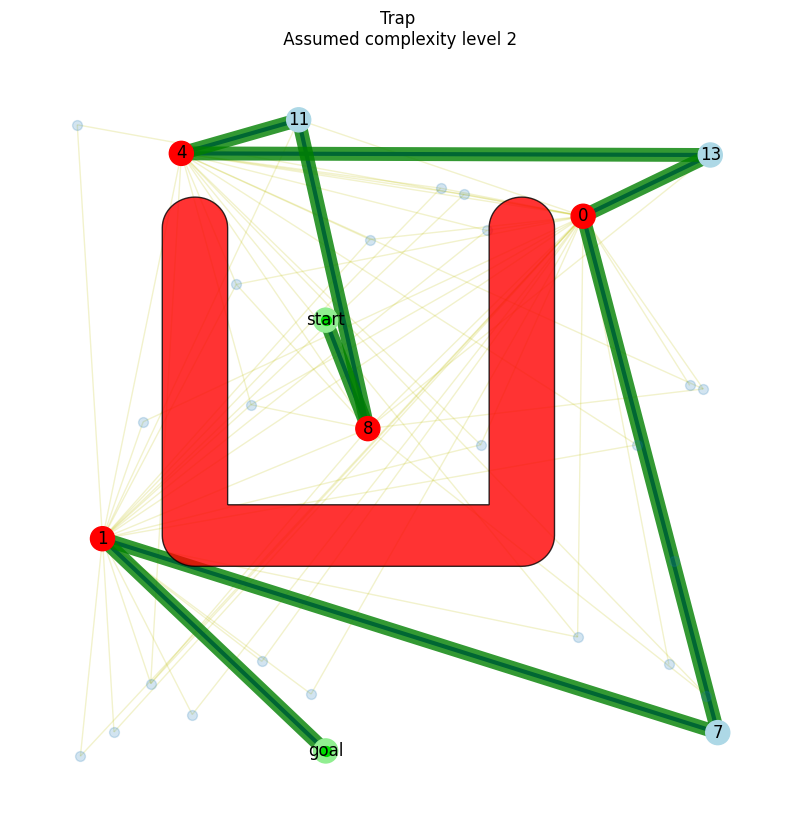

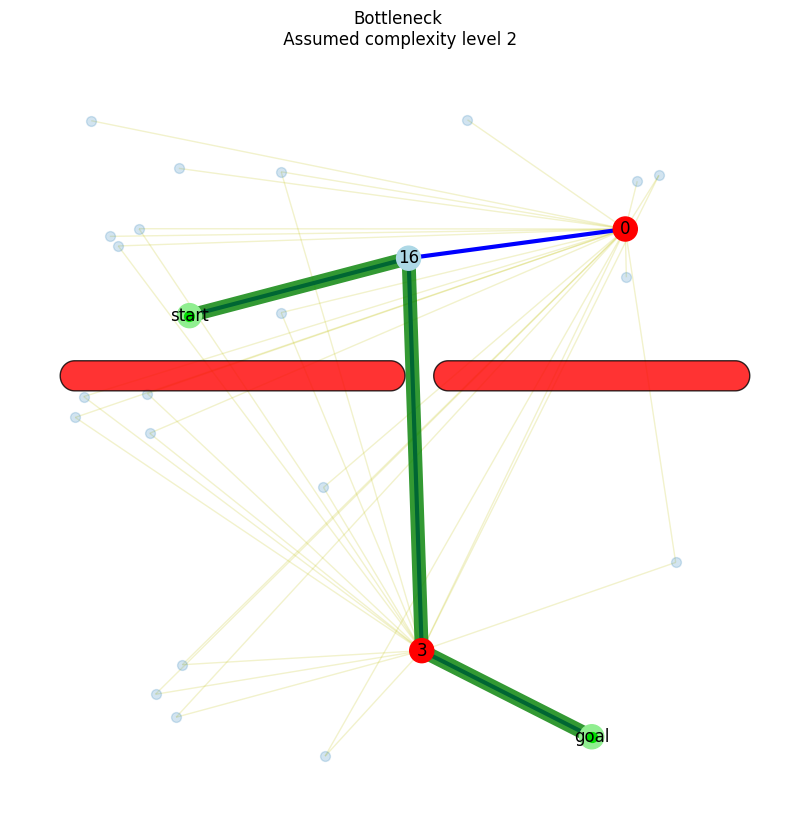

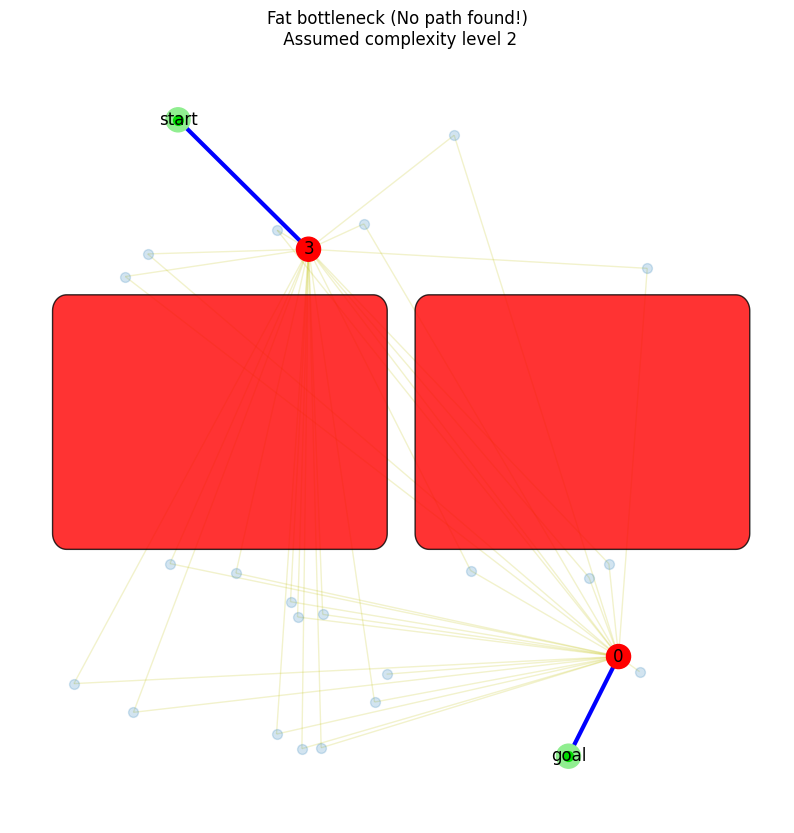

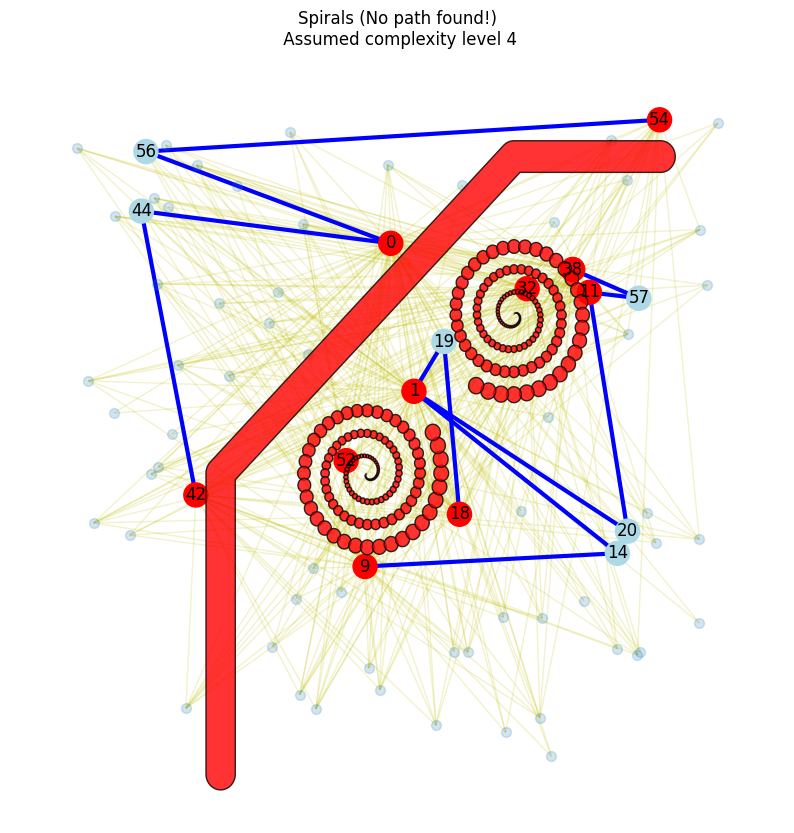

In [10]:

visConfig = dict()
visConfig["ntry"] = 20

for bench in benchList:
    try:
        fig_local = plt.figure(figsize=(10,10))
        ax = fig_local.add_subplot(1,1,1)
        statsHandler = VisibilityStatsHandler()
        vis = VisPRM(bench.collisionChecker, statsHandler)
        solution = vis.planPath(bench.startList, bench.goalList, visConfig)
        title = bench.name
        if solution == []:
            title += " (No path found!)"
        title += "\n Assumed complexity level " + str(bench.level)
        ax.set_title(title)
        visibilityPRMVisualize(vis, solution, ax=ax, nodeSize=50)
    except Exception as e:
        print("ERROR: ",bench.name, e)

Tasks / Excercises
==================

* Play with number of iterations (VisPRM(50,collChecker,statsHandler), VisPRM(300,collChecker,statsHandler))
* Test different environments (simpleField, trapField, fatBottleNeckField, bottleNeckField, clutteredField)
* Think of how to extend the collision checker (InnoKonz2dEnv.py or InnoKonzShapelyEnv.py) to gain more insights, e.g. how many collision tests where made, line tests were made, etc...